In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors

In [97]:
traindf = pd.read_csv("train-final.csv")
testdf = pd.read_csv("holdout-final.csv")
peptidedf = pd.read_csv("peptide-final.csv")

In [98]:
traininchi = [Chem.MolToInchiKey(Chem.MolFromSmiles(smi)) for smi in traindf.SMILES]
testinchi = [Chem.MolToInchiKey(Chem.MolFromSmiles(smi)) for smi in testdf.SMILES]
peptideinchi = [Chem.MolToInchiKey(Chem.MolFromSmiles(smi)) for smi in peptidedf.SMILES]

In [99]:
# make sure no overlap molecule
print(set(traininchi).intersection(set(testinchi)))
print(set(traininchi).intersection(set(peptideinchi)))

set()
set()


In [5]:
# Before building the model, lets look at the similarit y bettween the training and test sets
# The calculation takes 10+ minutes
def FPBitVec( fps ):
    X = []
    for item in fps:
        bv = DataStructs.ExplicitBitVect(4096)
        DataStructs.ExplicitBitVect.FromBase64(bv, item)
        X.append(bv)
    return X


xtrain = FPBitVec(traindf.ECFP6)
xtest = FPBitVec(holdoutdf.ECFP6)
xpeptide = FPBitVec(peptidedf.ECFP6)

train_test_max_similarity = [max(DataStructs.BulkTanimotoSimilarity(fps,xtrain)) for fps in xtest]
train_peptide_max_similarity = [max(DataStructs.BulkTanimotoSimilarity(fps,xtrain)) for fps in xpeptide]

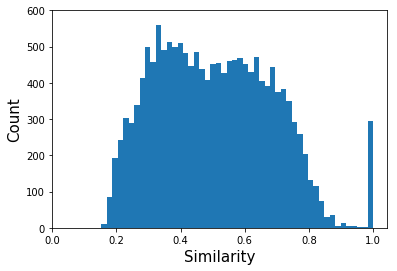

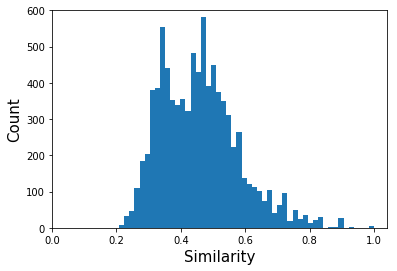

In [14]:
plt.hist(train_test_max_similarity,bins=50)
plt.xlabel("Similarity",size=15)
plt.ylabel("Count",size=15)
plt.xticks([0,.2,.4,.6,.8,1])
plt.ylim(0,600)
plt.savefig("train_test_sim.pdf",dpi=100,bbox_inches="tight")
plt.show()

plt.hist(train_peptide_max_similarity,bins=50)
plt.xlabel("Similarity",size=15)
plt.ylabel("Count",size=15)
plt.xticks([0,.2,.4,.6,.8,1])
plt.ylim(0,600)
plt.savefig("train_peptide_sim.pdf",dpi=100,bbox_inches="tight")
plt.show()

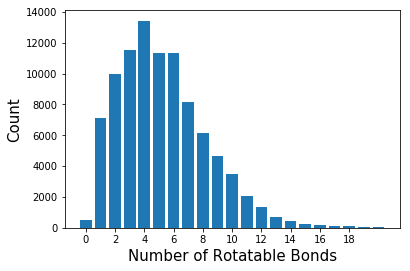

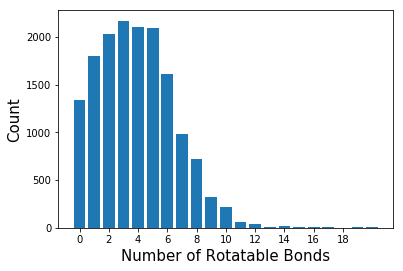

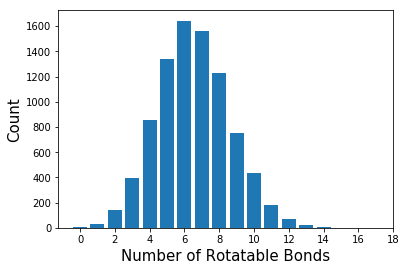

In [80]:
# Number of rotatable bonds in both training and testing sets
trainmol = [Chem.MolFromSmiles(smi) for smi in traindf.SMILES]
testmol = [Chem.MolFromSmiles(smi) for smi in testdf.SMILES]
peptidemol = [Chem.MolFromSmiles(smi) for smi in peptidedf.SMILES]
train_rotor = [rdMolDescriptors.CalcNumRotatableBonds(mol, strict=False) for mol in trainmol]
test_rotor = [rdMolDescriptors.CalcNumRotatableBonds(mol, strict=False) for mol in testmol]
peptide_rotor = [rdMolDescriptors.CalcNumRotatableBonds(mol, strict=False) for mol in peptidemol]

trainv, trainc = np.unique(train_rotor, return_counts=True)
testv, testc = np.unique(test_rotor, return_counts=True)
pepv,pepc = np.unique(peptide_rotor, return_counts=True)

plt.bar(trainv, trainc)
plt.xticks(list(range(0,20,2)))
plt.ylabel("Count",size=15)
plt.xlabel("Number of Rotatable Bonds",size=15)
plt.savefig("train_rotor.pdf",dpi=100,bbox_inches="tight")
plt.show()


plt.bar(testv, testc)
plt.xticks(list(range(0,20,2)))
plt.ylabel("Count",size=15)
plt.xlabel("Number of Rotatable Bonds",size=15)
plt.savefig("test_rotor.pdf",dpi=100,bbox_inches="tight")
plt.show()


plt.bar(pepv, pepc)
plt.xticks(list(range(0,20,2)))
plt.ylabel("Count",size=15)
plt.xlabel("Number of Rotatable Bonds",size=15)
plt.savefig("peptide_rotor.pdf",dpi=100,bbox_inches="tight")
plt.show()


# Model 1

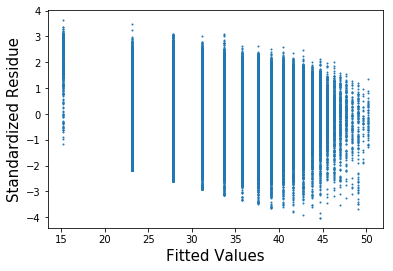

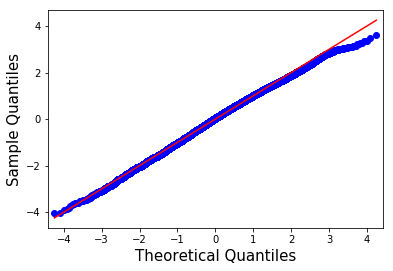

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                 2.817e+04
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        14:58:27   Log-Likelihood:            -3.5291e+05
No. Observations:               93021   AIC:                         7.058e+05
Df Residuals:                   93019   BIC:                         7.058e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              15.2430    

In [101]:
# Model 1
lm1 = ols('ConfEntropy~np.log1p(NumRotors)', traindf).fit()

# Residue Plot and Q-Q Plot
plt.scatter(lm1.fittedvalues,lm1.resid_pearson,s=1)
plt.xlabel("Fitted Values", size=15)
plt.ylabel("Standardized Residue", size=15)
plt.savefig("one_variable_model_residue_plot.pdf", dpi=100, bbox_inches="tight")
plt.show()

sm.qqplot(lm1.resid_pearson,line="s")
plt.xlabel("Theoretical Quantiles", size=15)
plt.ylabel("Sample Quantiles", size=15)
plt.savefig("one_variable_model_qqplot.pdf", dpi=100, bbox_inches="tight")
plt.show()

print(lm1.summary())

/home/lucian/anaconda3/envs/Chem/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


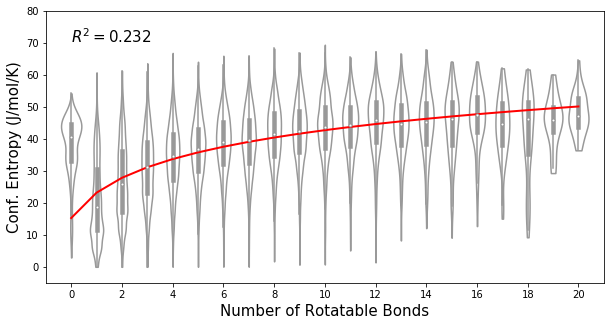

In [103]:
tmp  = traindf[["ConfEntropy","NumRotors"]]
plt.figure(figsize=(10,5))
sns.violinplot("NumRotors","ConfEntropy", data=tmp, color="white",cut=0)
x = pd.DataFrame({"NumRotors":list(range(21))}) 
plt.plot(list(range(21)), lm1.predict(x), color="r", lw=2)
plt.ylabel("Conf. Entropy (J/mol/K)",size=15)
plt.xlabel("Number of Rotatable Bonds", size=15)
plt.ylim(-5,80)
plt.xlim(-1,21)
plt.xticks(np.arange(0,21,2),list(range(0,21,2)))
plt.text(0,70,r"$R^{2}=0.232$",size=15)
plt.savefig("training_conf_entropy_vs_nrotors.pdf",dpi=100)
plt.show()

 # Model 2

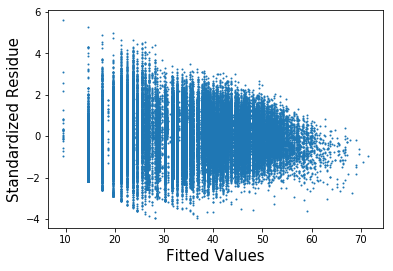

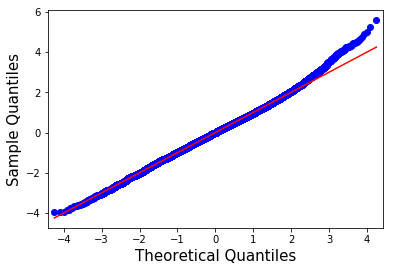

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                 1.061e+05
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:05:12   Log-Likelihood:            -3.0994e+05
No. Observations:               93021   AIC:                         6.199e+05
Df Residuals:                   93018   BIC:                         6.199e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               9.4922    

In [106]:
# Model 2
lm2 = ols('ConfEntropy~np.log1p(NumRotors)+np.log1p(NumMethyl)', traindf).fit()

# Residue Plot and  Q-Q Plot
plt.scatter(lm2.fittedvalues,lm2.resid_pearson,s=1)
plt.xlabel("Fitted Values", size=15)
plt.ylabel("Standardized Residue", size=15)
plt.savefig("two_variables_model_residue_plot.pdf", dpi=100, bbox_inches="tight")
plt.show()

sm.qqplot(lm2.resid_pearson,line="s")
plt.xlabel("Theoretical Quantiles", size=15)
plt.ylabel("Sample Quantiles", size=15)
plt.savefig("two_variables_model_qqplot.pdf", dpi=100, bbox_inches="tight")
plt.show()

print(lm2.summary())

# Model 3

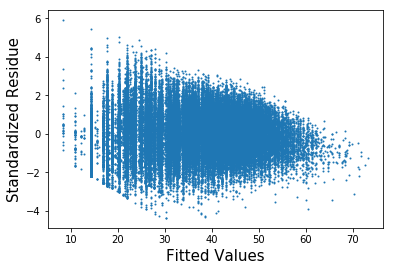

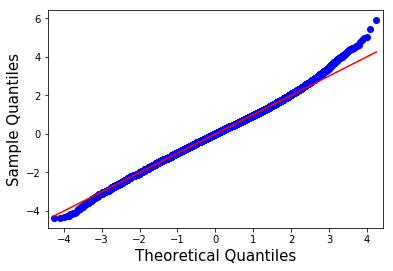

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                 7.598e+04
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:06:42   Log-Likelihood:            -3.0761e+05
No. Observations:               93021   AIC:                         6.152e+05
Df Residuals:                   93017   BIC:                         6.153e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               8.4022    

In [109]:
# Model 3
lm3 = ols('ConfEntropy~np.log1p(NumRotors)+np.log1p(NumMethyl)+np.log1p(SG)', traindf).fit()

# Residue Plot and  Q-Q Plot
plt.scatter(lm3.fittedvalues,lm3.resid_pearson,s=1)
plt.xlabel("Fitted Values", size=15)
plt.ylabel("Standardized Residue", size=15)
plt.savefig("three_variables_model_residue_plot.pdf", dpi=100, bbox_inches="tight")
plt.show()

sm.qqplot(lm3.resid_pearson,line="s")
plt.xlabel("Theoretical Quantiles", size=15)
plt.ylabel("Sample Quantiles", size=15)
plt.savefig("three_variables_model_qqplot.pdf", dpi=100, bbox_inches="tight")
plt.show()

print(lm3.summary())

# Model 4

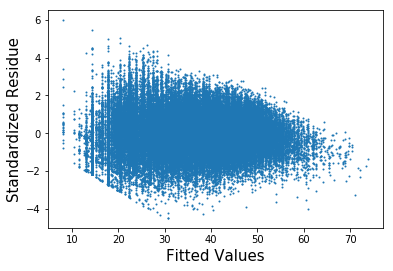

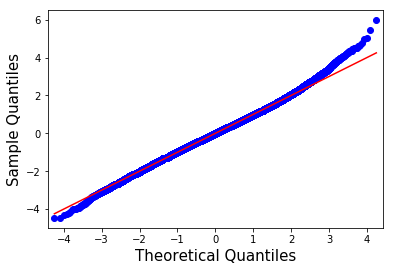

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                 4.642e+04
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:07:57   Log-Likelihood:            -3.0701e+05
No. Observations:               93021   AIC:                         6.140e+05
Df Residuals:                   93015   BIC:                         6.141e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               8.1389    

In [111]:
# Model 4
lm4 = ols('ConfEntropy~np.log1p(NumRotors)+np.log1p(NumMethyl)+np.log1p(SG)+np.log1p(HBond)+np.log1p(PiStack)'
          , traindf).fit()

# Residue Plot and  Q-Q Plot
plt.scatter(lm4.fittedvalues,lm4.resid_pearson,s=1)
plt.xlabel("Fitted Values", size=15)
plt.ylabel("Standardized Residue", size=15)
plt.savefig("five_variables_model_residue_plot.pdf", dpi=100, bbox_inches="tight")
plt.show()

sm.qqplot(lm4.resid_pearson,line="s")
plt.xlabel("Theoretical Quantiles", size=15)
plt.ylabel("Sample Quantiles", size=15)
plt.savefig("five_variables_model_qqplot.pdf", dpi=100, bbox_inches="tight")
plt.show()

print(lm4.summary())

# Model 5

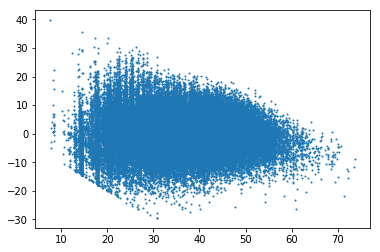

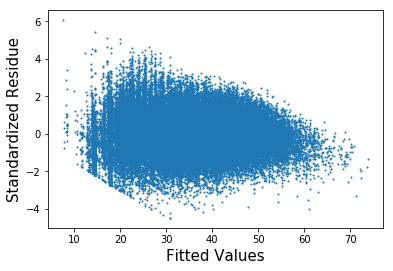

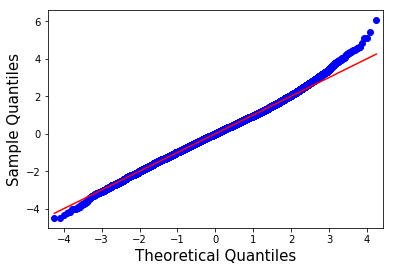

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                 3.874e+04
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:08:47   Log-Likelihood:            -3.0696e+05
No. Observations:               93021   AIC:                         6.139e+05
Df Residuals:                   93014   BIC:                         6.140e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               8.3595    

In [114]:
# Model 5
lm5 = ols('ConfEntropy~np.log1p(NumRotors)+np.log1p(NumMethyl)+np.log1p(SG)+np.log1p(HBond)+np.log1p(PiStack)+np.log1p(Ring)'
          , traindf).fit()

plt.scatter(lm5.fittedvalues,lm5.resid,s=1)
plt.show()
# Residue Plot and  Q-Q Plot
plt.scatter(lm5.fittedvalues,lm5.resid_pearson,s=1)
plt.xlabel("Fitted Values", size=15)
plt.ylabel("Standardized Residue", size=15)
plt.savefig("six_variables_model_residue_plot.pdf", dpi=100, bbox_inches="tight")
plt.show()

sm.qqplot(lm5.resid_pearson,line="s")
plt.xlabel("Theoretical Quantiles", size=15)
plt.ylabel("Sample Quantiles", size=15)
plt.savefig("six_variables_model_qqplot.pdf", dpi=100, bbox_inches="tight")
plt.show()


print(lm5.summary())

# Performance on Holdout Test Set and Peptides Test Set

In [115]:
# Training set
print("Model 1 MAE (Trianing set): %.3f" %(mean_absolute_error(traindf["ConfEntropy"],lm1.predict(traindf))))
print("Model 2 MAE (Trianing set): %.3f" %(mean_absolute_error(traindf["ConfEntropy"],lm2.predict(traindf))))
print("Model 3 MAE (Trianing set): %.3f" %(mean_absolute_error(traindf["ConfEntropy"],lm3.predict(traindf))))
print("Model 4 MAE (Training set): %.3f" %(mean_absolute_error(traindf["ConfEntropy"],lm4.predict(traindf))))
print("Model 5 MAE (Training set): %.3f" %(mean_absolute_error(traindf["ConfEntropy"],lm5.predict(traindf))))

Model 1 MAE (Trianing set): 8.665
Model 2 MAE (Trianing set): 5.337
Model 3 MAE (Trianing set): 5.193
Model 4 MAE (Training set): 5.159
Model 5 MAE (Training set): 5.155


In [117]:
# Holdout test set
print("Model 1 MAE (holdout test-set): %.3f" %(mean_absolute_error(testdf["ConfEntropy"],lm1.predict(testdf))))
print("Model 2 MAE (holdout test-set): %.3f" %(mean_absolute_error(testdf["ConfEntropy"],lm2.predict(testdf))))
print("Model 3 MAE (holdout test-set): %.3f" %(mean_absolute_error(testdf["ConfEntropy"],lm3.predict(testdf))))
print("Model 4 MAE (holdout test-set): %.3f" %(mean_absolute_error(testdf["ConfEntropy"],lm4.predict(testdf))))
print("Model 5 MAE (holdout test-set): %.3f" %(mean_absolute_error(testdf["ConfEntropy"],lm5.predict(testdf))))

Model 1 MAE (holdout test-set): 8.832
Model 2 MAE (holdout test-set): 4.887
Model 3 MAE (holdout test-set): 4.793
Model 4 MAE (holdout test-set): 4.758
Model 5 MAE (holdout test-set): 4.767


In [118]:
# Peptides test set
print("MAE (peptides test-set): %.3f" %(mean_absolute_error(peptidedf["ConfEntropy"],lm1.predict(peptidedf))))
print("MAE (peptides test-set): %.3f" %(mean_absolute_error(peptidedf["ConfEntropy"],lm2.predict(peptidedf))))
print("MAE (peptides test-set): %.3f" %(mean_absolute_error(peptidedf["ConfEntropy"],lm3.predict(peptidedf))))
print("MAE (peptides test-set): %.3f" %(mean_absolute_error(peptidedf["ConfEntropy"],lm4.predict(peptidedf))))
print("MAE (peptides test-set): %.3f" %(mean_absolute_error(peptidedf["ConfEntropy"],lm5.predict(peptidedf))))

MAE (peptides test-set): 9.004
MAE (peptides test-set): 4.623
MAE (peptides test-set): 5.049
MAE (peptides test-set): 4.704
MAE (peptides test-set): 4.654
